In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
import os
import sys
from pathlib import Path
module_path = os.path.abspath(os.path.join('..'))
parent_module_path = Path.cwd().parent
src_module_path = parent_module_path / "src"
if module_path not in sys.path:
    sys.path.append(module_path)
# if parent_module_path not in sys.path:
#     sys.path.append(parent_module_path)
# if src_module_path not in sys.path:
#     sys.path.append(src_module_path)

In [3]:
import functools
import operator
import random
from pprint import pprint
from typing import Callable

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as F
from src.dataset import get_kaggle_cat_dog_dataset
from src.funcs import get_dataloaders
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.models import ResNet, resnet18
from torchvision.utils import make_grid
from tqdm import tqdm, trange


## Utility Functions

In [4]:
def show_images(
    imgs: 'list[torch.Tensor]',
    num_row: int = 2,
    num_col: int = 2,
):
    title_font = {'fontname': 'monospace', 'size': '10', 'color': 'black', 'weight': 'normal',
                  'verticalalignment': 'bottom'}
    fig, axes = plt.subplots(
        num_row, num_col,
    )
    fig.set_dpi(100)

    axes: 'list[matplotlib.axes._subplots.AxesSubplot]' = functools.reduce(operator.iconcat, axes, [])
    for i in range(len(axes)):
        img = imgs[i].detach()
        img = F.to_pil_image(img)
        axes[i].imshow(img)
        axes[i].set_xticklabels([])
        axes[i].set_yticklabels([])
        axes[i].set_aspect('equal')
        # axes[i].set_title(label_names[labels[i]], **title_font)
        axes[i].set_axis_off()
    return fig, axes


def train_one_epoch(
    model: nn.Module,
    train_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: nn.Module,
    device: torch.device,
):
    # constant
    train_size = len(train_dataloader.dataset)

    # return variable
    running_loss = 0  # total loss of one epoch
    avg_running_loss = 0
    avg_sole_batch_loss_list = []
    total_correct_num = 0  # num of correct pred
    acc = 0

    for batch_sample in tqdm(
        train_dataloader,
        desc="Batch training",
        leave=True,
        total=len(train_dataloader)
    ):
        inputs: torch.Tensor
        labels: torch.Tensor
        inputs, labels = batch_sample

        # move to device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds: torch.Tensor = model(inputs)
        loss: torch.Tensor = loss_fn(preds, labels)  # return avg loss of current batch
        loss.backward()
        optimizer.step()

        # statistics
        avg_sole_batch_loss = loss.detach().item()
        sole_batch_loss = avg_sole_batch_loss * inputs.size(0)  # compute total single batch loss
        running_loss += sole_batch_loss
        correct_num = (preds.argmax(1) == labels).type(torch.float).sum().item()
        total_correct_num += correct_num

        avg_sole_batch_loss_list.append(avg_sole_batch_loss)

    avg_running_loss = running_loss / train_size
    acc = (total_correct_num / train_size) * 100

    return avg_running_loss, avg_sole_batch_loss_list, int(total_correct_num), acc


## Experimental Code

In [5]:
# check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(type(device))
print(torch.cuda.device_count())

<class 'torch.device'>
1


In [6]:
model = resnet18(
    pretrained=False,
    num_classes=2
)
model = model.to(device)

In [7]:
# batch_size = 256
# train_shuffle = True

# transform_train = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.RandomCrop((224, 224), padding=4),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     # tr_normalize,
#     transforms.Lambda(lambda x: x.float())
# ])

# kaggle_cat_dog_dataset = get_kaggle_cat_dog_dataset(
#     data_dir = '../_dataset/dogs-vs-cats/train',
#     transform=transform_train
# )

# train_dataset = kaggle_cat_dog_dataset
# train_loader = DataLoader(train_dataset,
#                           batch_size=batch_size,
#                           shuffle=train_shuffle,
#                           num_workers=4,
#                           )


In [8]:
train_loader, test_loader = get_dataloaders(
    dataset="Kaggle-Cat-Dog",
    batch_size=256,
    normalize=True,
    download=False,
    pseudo_labels=False,
    concat=False,
)


(<Figure size 600x400 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

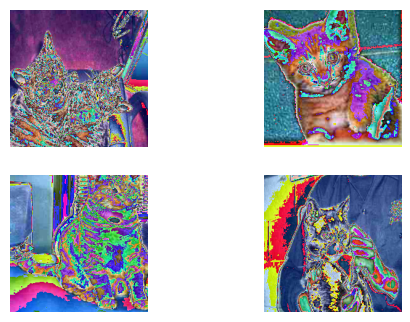

In [9]:
imgs, labels = next(iter(train_loader))
show_images(imgs)

In [10]:
# loss function & optimizer & lr scheduler
loss_fn = torch.nn.CrossEntropyLoss().to(device)


# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# cifar10
# optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
# num_epochs = 100
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs * 0.3), int(num_epochs * 0.8)], gamma=0.1)

# STL10
# optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
# num_epochs = 200
# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs * 0.3), int(num_epochs * 0.8)], gamma=0.1)

# Kaggle
optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
num_epochs = 50
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs * 0.3), int(num_epochs * 0.8)], gamma=0.1)


In [11]:
# start training
train_epoch_acc_list = []
train_epoch_avg_loss_list = []
train_mini_batch_avg_loss_list = []
latest_train_correct_num = 0
latest_train_acc = 0

val_epoch_acc_list = []
val_epoch_avg_loss_list = []
val_mini_batch_avg_loss_list = []
latest_val_correct_num = 0
latest_val_acc = 0

for epoch in range(num_epochs):
    # training
    result = train_one_epoch(
        model=model,
        train_dataloader=train_loader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        device=device,
    )
    train_avg_running_loss, train_avg_sole_batch_loss_list, \
        train_total_correct_num, train_acc = result

    train_epoch_acc_list.append(train_acc)
    train_epoch_avg_loss_list.append(train_avg_running_loss)
    train_mini_batch_avg_loss_list.extend(train_avg_sole_batch_loss_list)
    latest_train_correct_num = train_total_correct_num
    latest_train_acc = train_acc

    # learning rate schedulers
    scheduler.step()

    print(f'{epoch+1:02d} | train_avg_running_loss: {train_avg_running_loss:0.4f}, train_acc: {train_acc:0.2f}')


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

01 | train_avg_running_loss: 0.9238, train_acc: 53.77


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

02 | train_avg_running_loss: 0.6847, train_acc: 56.02


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

03 | train_avg_running_loss: 0.6726, train_acc: 58.26


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

04 | train_avg_running_loss: 0.6418, train_acc: 63.43


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

05 | train_avg_running_loss: 0.6282, train_acc: 65.13


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

06 | train_avg_running_loss: 0.5912, train_acc: 68.48


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

07 | train_avg_running_loss: 0.5539, train_acc: 71.99


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

08 | train_avg_running_loss: 0.5112, train_acc: 75.04


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

09 | train_avg_running_loss: 0.4798, train_acc: 77.21


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

10 | train_avg_running_loss: 0.4458, train_acc: 79.18


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

11 | train_avg_running_loss: 0.4187, train_acc: 80.91


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

12 | train_avg_running_loss: 0.3808, train_acc: 83.10


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

13 | train_avg_running_loss: 0.3558, train_acc: 84.16


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

14 | train_avg_running_loss: 0.3281, train_acc: 85.51


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

15 | train_avg_running_loss: 0.2961, train_acc: 87.25


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

16 | train_avg_running_loss: 0.2363, train_acc: 90.00


Batch training:   0%|          | 0/98 [00:00<?, ?it/s]

17 | train_avg_running_loss: 0.2129, train_acc: 91.03


Batch training:  69%|██████▉   | 68/98 [00:49<00:21,  1.38it/s]


KeyboardInterrupt: 

In [ ]:
save_pt_file = "/data/weijing/ting-dataset-inference/_resnet_model/resnet-18_cifar10-cat-dog_02.pt"
torch.save(model.state_dict(), save_pt_file)

In [ ]:
# num_epochs = 50
# def step_lr(
#         num_epochs: int
# ) -> 'Callable':
#     '''
#     Step learning rate mentioned in author paper in `6.1 MODEL STEALING ATTACK (pg07)`
#     '''
#     def step_lr_func(epoch: int):
#         ratio = epoch/float(num_epochs)
#         if ratio < 0.3:
#             return 1
#         elif ratio < 0.6:
#             return 1*0.2
#         elif ratio < 0.8:
#             return 1*0.2*0.2
#         else:
#             return 1*0.2*0.2*0.2

#     return step_lr_func


# model = torch.nn.Linear(2, 1)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# def lambda1(epoch): return 0.65 ** epoch


# # scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=step_lr(num_epochs))
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

# lrs = []

# for i in range(num_epochs):
#     optimizer.step()
#     lrs.append(optimizer.param_groups[0]["lr"])
#     # print("Factor = ", step_lr(num_epochs)(i), " , Learning Rate = ", round(optimizer.param_groups[0]["lr"], 5))
#     scheduler.step()

# plt.plot(range(num_epochs), lrs)
